## Homework Assingment 3
## ATMS523
## Author: Domenic Brooks

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings("ignore")

# Part 1

In [ ]:
# Station selection function
def select_station(city):
    """ 
    This function returns the GHCN-d station ID based on the city/town
    you input and allows you to select the specfiic station from
    a dropdown menu.

    Inputs:
        city (str): City/town name you want station data from 
        (MUST BE IN ALL CAPITAL LETTERS). 

    Outputs:
        selected_id (dict): Station ID and name based on dropdown menu selection.
    """
    
    # Read in available stations
    stn_ids = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt', 
                          header=None, infer_nrows=1000)
    stn_ids.columns = ['ID','LAT','LON','ELEV','UKN','NAME','GSN','WBAN']

    # Read in station inventory file (gives years available for each variable)
    periods = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt', 
                          header=None, infer_nrows=1000)
    periods.columns = ['ID','LAT','LON','ELEM','TiMIN','TiMAX']

    # Merge the inventory and station dfs based on ID
    merged_stns = pd.merge(stn_ids,periods,how='left',left_on='ID',right_on='ID')

    # Grab stations where TMAX data is availble up to 2025
    # TiMIN is the earliest year available
    # TiMAX is the most recent year available
    merged_stns = merged_stns[(merged_stns['ELEM'] == 'TMAX') & 
                              (merged_stns['TiMAX'] == 2025)]

    # Select staions with city in name
    merged_stns = merged_stns[merged_stns['NAME'].str.contains(city, regex=False)]

    if merged_stns.empty:
        print(f"No stations found for city: {city}")
        return None

    # Create dropdown options (include empty option first)
    # Including the empty option allows callback to 
    # work properly when selection is made.
    options = {'-- Select a Station --': None}
    for _, row in merged_stns.iterrows():
        label = f"{row['NAME']} ({row['ID']})"
        options[label] = row['ID']

    dropdown = widgets.Dropdown(
        options=options,
        value=None,  # Ensures no pre-selection
        description='Station:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='70%')
    )

    output = widgets.Output()
    
    # Store both ID and name
    selected_station = {'id': None, 'name': None}

	
    def on_select(change):
        """
        Function to return station info based on selection.
        """
        if change.new:  # Only trigger when a station is chosen
            stn = merged_stns[merged_stns['ID'] == change.new].iloc[0]
            selected_station['id'] = stn['ID']
            selected_station['name'] = stn['NAME']
			# Print station metadata
            with output:
                clear_output()
                print("Selected Station:")
                print(stn[['ID', 
                           'NAME', 
                           'LAT_x', 
                           'LON_x', 
                           'ELEV', 
                           'TiMIN', 
                           'TiMAX']])

	# Display dropdown menu
    dropdown.observe(on_select, names='value')
    display(dropdown, output)

    print("Please choose a station from the dropdown above.")
    return selected_station

# Station data retrieval funciton
def get_station_data(station_id):
    """
    This function grabs the data from the selected station and returns
    a dataframe with the record min and max temp from each calendar day
    over the period of record, as well as the mean min and max daily
    temps for the 1991-2020 period.

    Inputs:
        station_id (str): Station ID of selected station, default is the one you
        selected using the previous function.

    Outputs:
        df_records (pd.DataFrame): The dataframe containing average_max_temp,
        average_min_temp, record_max_temp, and record_min_temp. 

        df_tmin (pd.DataFrame): Daily min temps for the period of record.

        df_tmax (pd.DataFrame): Daily max temps for the period of record.
    """

    # Read in actual data for selected station from AWS
    df = pd.read_csv(
        f"s3://noaa-ghcn-pds/csv/by_station/{station_id}.csv",
        storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
        dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
        parse_dates=['DATE']
    ).set_index('DATE')

    # Grab max and min temps (in tenths of degrees C)
    df_tmax = df.loc[df['ELEMENT'] == 'TMAX']
    df_tmin = df.loc[df['ELEMENT'] == 'TMIN']

    # Convert GHCN temps from tenths of °C to °C
    df_tmin["TMIN"] = df_tmin["DATA_VALUE"] / 10
    df_tmax["TMAX"] = df_tmax["DATA_VALUE"] / 10

    # Add month-day identifier
    df_tmin["MONTH_DAY"] = df_tmin.index.strftime("%m-%d")
    df_tmax["MONTH_DAY"] = df_tmax.index.strftime("%m-%d")

    # Group by month-day and find all time max/min
    df_tmax_daily = (
        df_tmax.groupby(['MONTH_DAY'], as_index=True)
        .agg(record_max_temp=('TMAX','max'))
    )

    df_tmin_daily = (
        df_tmin.groupby(['MONTH_DAY'], as_index=True)
        .agg(record_min_temp=('TMIN','min'))
    )

    # Now get 1991-2020 averages
    df_91_20_max = df_tmax[(df_tmax.index >= pd.to_datetime('1991-01-01')) & 
                           (df_tmax.index <= pd.to_datetime('2020-01-01'))]
    df_91_20_min = df_tmin[(df_tmin.index >= pd.to_datetime('1991-01-01')) & 
                           (df_tmin.index <= pd.to_datetime('2020-01-01'))]

    # Group by month-day and find means
    df_tmax_daily_mean = (
        df_91_20_max.groupby(['MONTH_DAY'], as_index=True)
        .agg(average_max_temp=('TMAX','mean'))
    )

    df_tmin_daily_mean = (
        df_91_20_min.groupby(['MONTH_DAY'], as_index=True)
        .agg(average_min_temp=('TMIN','mean'))
    )

    # Merge all dataframes
    df_records = pd.concat([df_tmax_daily_mean, 
                            df_tmin_daily_mean, 
                            df_tmax_daily, 
                            df_tmin_daily], 
                            axis=1)

    # Drop unecessary columns
    df_tmax.drop(['ID',
                  'ELEMENT', 
                  'DATA_VALUE',	
                  'M_FLAG', 
                  'Q_FLAG', 
                  'S_FLAG', 
                  'OBS_TIME'],
                  axis=1, inplace=True)
    
    df_tmin.drop(['ID',
                  'ELEMENT', 
                  'DATA_VALUE',	
                  'M_FLAG', 
                  'Q_FLAG', 
                  'S_FLAG', 
                  'OBS_TIME'], 
                 axis=1, inplace=True)

    return df_records, df_tmin, df_tmax


In [ ]:
# Need to run seperately from the other function
# because Jupyter Notebook cells cannot pause to wait for 
# user input for the callback.
city = 'BOSTON'
s = select_station(city)

Dropdown(description='Station:', layout=Layout(width='70%'), options={'-- Select a Station --': None, 'NEW BOS…

Output()

Please choose a station from the dropdown above.


In [215]:
# Can use output from the selection function,
# or manually input the station ID.
df_records, df_tmin, df_tmax = get_station_data(s['id'])
df_records

,average_max_temp,average_min_temp,record_max_temp,record_min_temp
MONTH_DAY,,,,
01-01,11.460000,-2.206667,21.7,-18.9
01-02,11.741379,-1.800000,26.1,-15.0
01-03,9.786207,-1.437931,20.0,-14.4
01-04,9.793103,-2.351724,23.3,-13.3
01-05,11.155172,-2.513793,23.3,-15.6
...,...,...,...,...
12-27,8.975862,-3.179310,24.4,-17.8
12-28,10.775862,-2.934483,23.9,-11.1
12-29,10.213793,-2.406897,24.4,-12.2


# Part 2

In [ ]:
from scipy.signal import savgol_filter
from bokeh.models import ColumnDataSource, DataRange1d, HoverTool
from bokeh.palettes import RdBu11
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

# Plot (using Bokeh library)
def plot_station_data_year(year, smoothed=False):
	"""
	Create plot of daily temperature record for selected station
	and a given year.

	Inputs:
		year (int): Year you want to grab data from, must be valid year within 
		period of record for the given station.

		smoothed (bool): Set to True if you want to apply 30-day smoothing window.
	"""
	# Select data from given year
	df_max_year = df_tmax[(df_tmax.index >= pd.to_datetime(f'{year}-01-01')) &
					      (df_tmax.index <= pd.to_datetime(f'{year}-12-31'))]
	df_min_year = df_tmin[(df_tmin.index >= pd.to_datetime(f'{year}-01-01')) & 
					      (df_tmin.index <= pd.to_datetime(f'{year}-12-31'))]

	# Handle leap years
	if year % 4 != 0:
		df_records2 = df_records.drop('02-29')
	else:
		df_records2 = df_records

	# Get datetime index
	dates = df_max_year.index

	# Reset indices for merge
	df_max_year = df_max_year.set_index('MONTH_DAY')
	df_min_year = df_min_year.set_index('MONTH_DAY')

	# Merge with df_records
	merged = pd.concat([df_max_year, df_min_year, df_records2], axis=1)
	merged = merged.reset_index()

	# Set index as the dates
	df_year = merged.set_index(dates)

	# Smooth lines if desired
	if smoothed==True:
		df_year.drop('MONTH_DAY', axis=1, inplace=True)
		for key in df_year.columns:
			window, order = 30, 3 # Window of n days, 3rd degree polynomial
			df_year[key] = savgol_filter(df_year[key], window, order)

	# Plotting 
	plot = figure(x_axis_type="datetime",
			      width=1200,
				  tools='pan,wheel_zoom,box_zoom,reset',
				  toolbar_location='above')

	# Configure hover tool to show data properly
	hover = HoverTool(
		tooltips=[
			("Date", "@left{%F}"), # Formatted datetime
			("Record Max (°C)", "@record_max_temp"),
			("Record Min (°C)", "@record_min_temp"),
			("Average Max (°C)", "@average_max_temp"),
			("Average Min (°C)", "@average_min_temp"),
			("Actual Max (°C)", "@TMAX"),
			("Actual Min (°C)", "@TMIN"),
		],
		formatters={
			"@left": "datetime" # Ensure date formatting
		},
		mode="mouse" # Show data only when mouse intersects data point
	)
	plot.add_tools(hover)

	# Change title if smootheed
	if smoothed==True:
		plot.title.text = (f'Daily Temperature Record for {year} for Station' 
					 	   f' {s["id"]} ({s["name"]})'
					       f'\n(Using 1991-2020 Average)'
					       f'\nSmoothed Over {window} Day Window')
	else:
		plot.title.text = (f'Daily Temperature Record for {year} for Station'
					       f' {s["id"]} ({s["name"]})'
					       f'\n(Using 1991-2020 Average)')
		
	# For Bokeh, you need to create a ColumnDataSource (CDS) from the dataframe,
	# with the names of the columns in the CDS correspond to those in the df.
	# Also need to define the left and right edges of each data point to plot with quad.
	df_year["left"] = df_year.index
	df_year["right"] = df_year.index + pd.Timedelta(days=1)
	source = ColumnDataSource(df_year)

	plot.quad(top='record_max_temp', 
		   	  bottom='record_min_temp', 
			  left='left', 
		   	  right='right', 
			  color=RdBu11[7], 
			  source=source, 
			  legend_label="Record") # Records

	plot.quad(top='average_max_temp', 
		      bottom='average_min_temp', 
			  left='left', right='right',
			  color=RdBu11[2], source=source, 
			  legend_label="Average") # Averages
	
	plot.quad(top='TMAX', 
		      bottom='TMIN', 
			  left='left', 
			  right='right',
			  color=RdBu11[0], 
			  source=source, 
			  alpha=0.5, 
			  line_color="black", 
			  legend_label="Actual") # Actual

	# Plot attributes
	plot.xaxis.axis_label = 'Day of Year'
	plot.yaxis.axis_label = "Temperature (C)"
	plot.axis.axis_label_text_font_style = "bold"
	plot.x_range = DataRange1d(range_padding=0.0)
	plot.grid.grid_line_alpha = 0.8

	show(plot) # Show plot

year = 2024
smoothed=False
plot_station_data_year(year, smoothed)

Loading BokehJS ...

#### Screenshot of plot if does not load in github properly
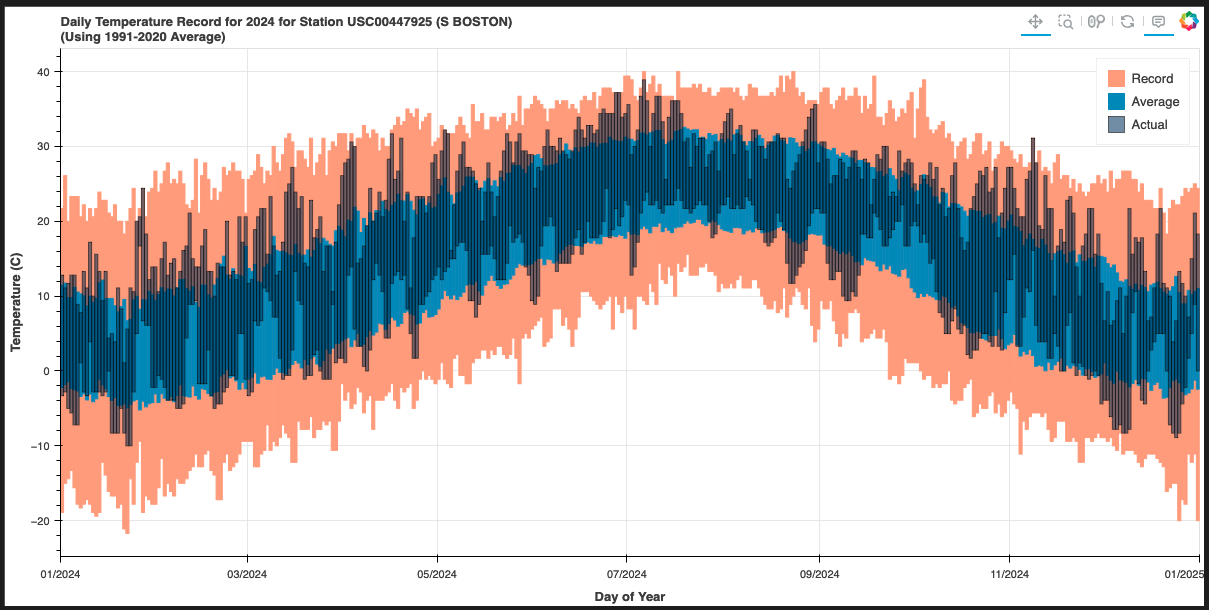